In [34]:
%load_ext autoreload
%autoreload
%matplotlib inline
import gdal
import os
import glob
from gdalconst import *
import matplotlib.pyplot as plt
import numpy as np
# osgeo (gdal related)
# rasterio
# berkeley tree data
import sys
sys.path.insert(0, "../src")
import satellite_analyze

In [3]:
def attempt_color(r, g, b):
    data_r = ds_all.GetRasterBand(r).ReadAsArray(x_pos, y_pos, x_del, y_del)
    data_g = ds_all.GetRasterBand(g).ReadAsArray(x_pos, y_pos, x_del, y_del)
    data_b = ds_all.GetRasterBand(b).ReadAsArray(x_pos, y_pos, x_del, y_del)
    data = [data_r, data_g, data_b]
    data_rgb = np.zeros((x_del, y_del, 3))
    for (data_id, data) in enumerate(data):
        data_rgb[:, :, data_id] = data
    data_rgb /= np.max(data_rgb)
    imgplot = plt.imshow(data_rgb)
    print('r', r, 'g', g, 'b', b)
    plt.show()

In [7]:
filename = '../data/raw/athens_satellite.tif'
outpath = '../raster_out'

In [35]:
ds_all= gdal.Open(filename, GA_ReadOnly)

In [9]:
type(ds_all)

osgeo.gdal.Dataset

In [36]:
ds_all.GetMetadata()

{'AREA_OR_POINT': 'Area',
 'TIFFTAG_RESOLUTIONUNIT': '2 (pixels/inch)',
 'TIFFTAG_SOFTWARE': 'ERDAS IMAGINE',
 'TIFFTAG_XRESOLUTION': '1',
 'TIFFTAG_YRESOLUTION': '1'}

In [42]:
ds_all.GetRasterBand(1)

<osgeo.gdal.Band; proxy of <Swig Object of type 'GDALRasterBandShadow *' at 0x1143de990> >

In [44]:
from osgeo import gdal

# unravel GDAL affine transform parameters
c, a, b, f, d, e = ds_all.GetGeoTransform()

def pixel2coord(col, row):
    """Returns global coordinates to pixel center using base-0 raster index"""
    xp = a * col + b * row + a * 0.5 + b * 0.5 + c
    yp = d * col + e * row + d * 0.5 + e * 0.5 + f
    return(xp, yp)

# Getting Dataset Information

In [47]:
# adfGeoTransform[0] /* top left x */
# adfGeoTransform[1] /* w-e pixel resolution */
# adfGeoTransform[2] /* 0 */
# adfGeoTransform[3] /* top left y */
# adfGeoTransform[4] /* 0 */
# adfGeoTransform[5] /* n-s pixel resolution (negative value) */

dataset = ds_all
print("Driver: {}/{}".format(dataset.GetDriver().ShortName,
                             dataset.GetDriver().LongName))
print("Size is {} x {} x {}".format(dataset.RasterXSize,
                                    dataset.RasterYSize,
                                    dataset.RasterCount))
print("Projection is {}".format(dataset.GetProjection()))
geotransform = dataset.GetGeoTransform()
if geotransform:
    print("Origin = ({}, {})".format(geotransform[0], geotransform[3]))
    print("Pixel Size = ({}, {})".format(geotransform[1], geotransform[5]))


Driver: GTiff/GeoTIFF
Size is 43757 x 43589 x 4
Projection is PROJCS["IMAGINE GeoTIFF Support
ERDAS IMAGINE 2014  14.0.0.181
Projection = Transverse Mercator",GEOGCS["EGSA87",DATUM["EGSA87",SPHEROID["GRS 1980",6378137,298.2572220960422,AUTHORITY["EPSG","7019"]]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",24],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["meters",1]]
Origin = (469505.999594, 4210645.52923)
Pixel Size = (0.3, -0.3)


In [45]:
(x, y) = pixel2coord(0, 0)

In [46]:
print(x,y)

(469506.1495942082, 4210645.379225904)


In [7]:
print('X', ds_all.RasterXSize)
print('Y', ds_all.RasterXSize)
print('Bands', ds_all.RasterCount)

('X', 43757)
('Y', 43757)
('Bands', 4)


In [8]:
np.arange(1,4)

array([1, 2, 3])

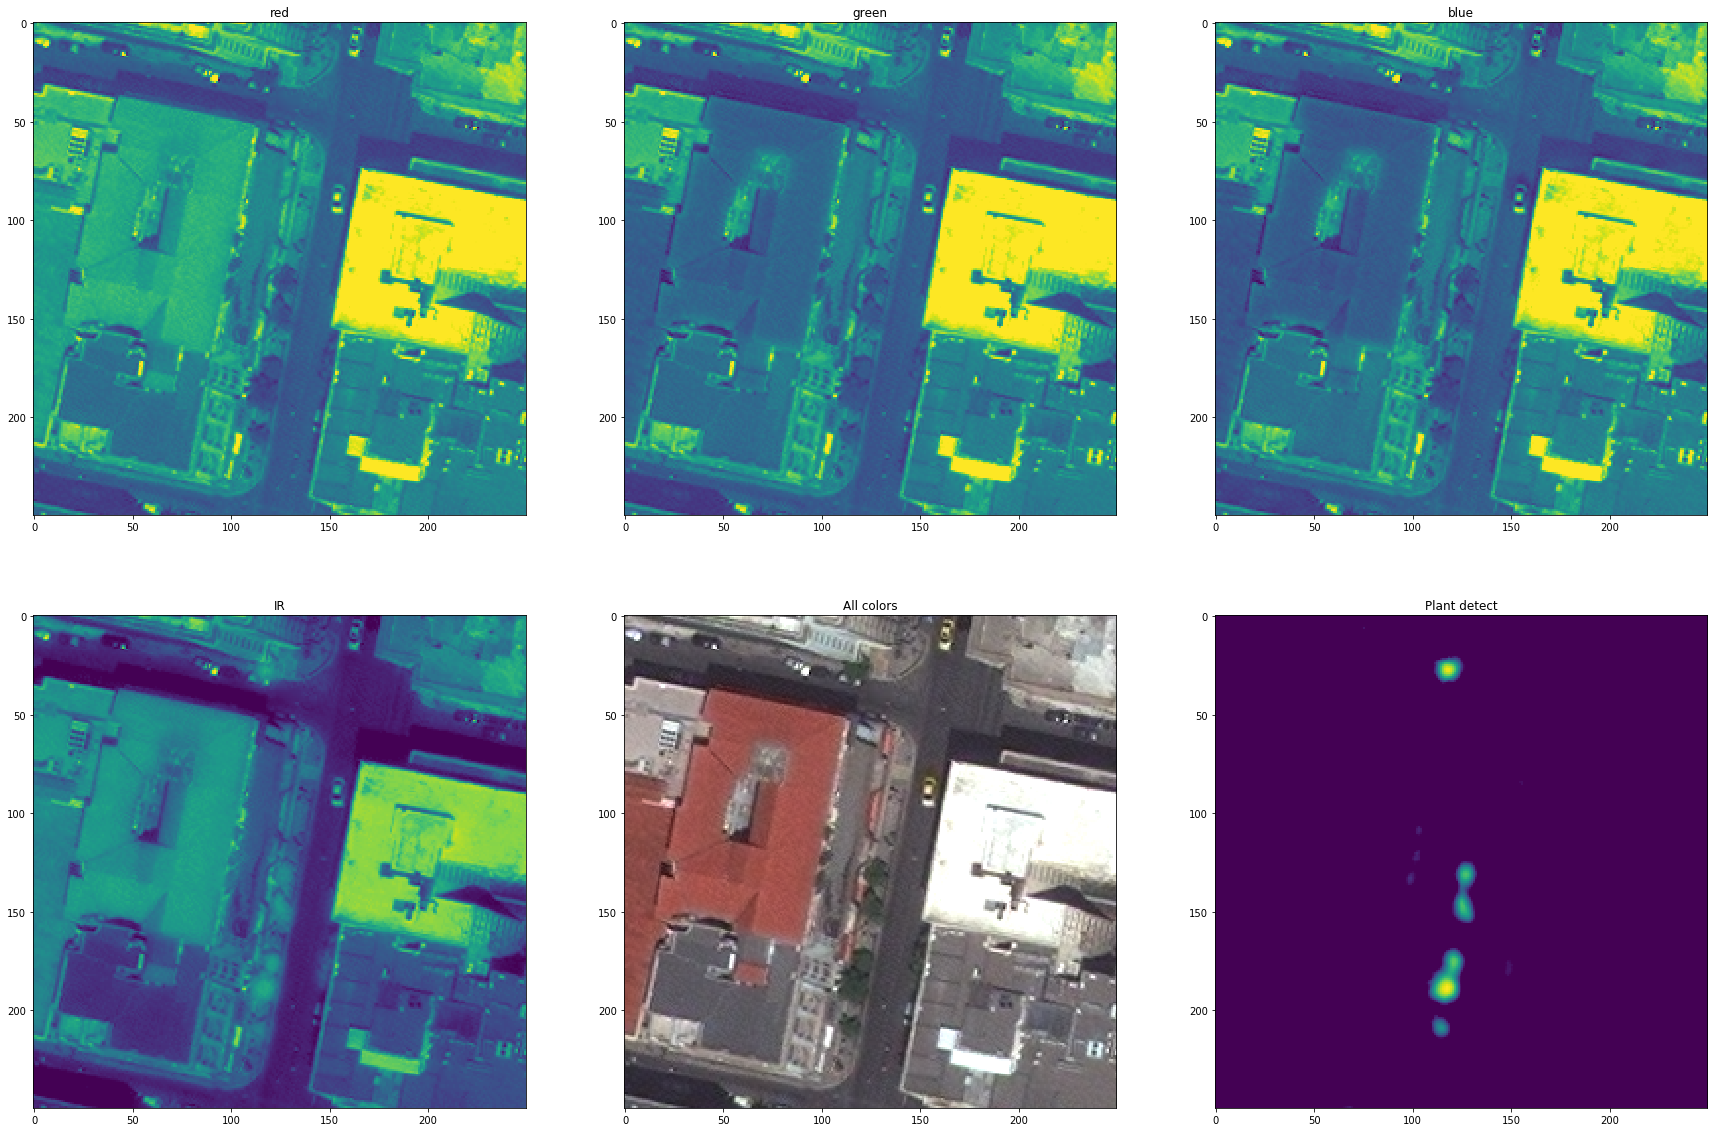

In [18]:
# band 1: red
# band 2: green
# band 3: blue
# band 4: ??
x_del = 250
y_del = 250
x_center = ds_all.RasterXSize // 2
y_center = ds_all.RasterYSize // 2
x_shift = 100
y_shift = -100
x_pos = x_center + x_shift
y_pos = y_center + y_shift
channels = 3
data_all = np.zeros((x_del, y_del, 4))
data_sum = np.zeros((x_del, y_del))
color_scheme = ['red', 'green', 'blue',  'IR']
fig, axs = plt.subplots(2,3,figsize=(30,20))
axs = np.reshape(axs, [6,])
for index in np.arange(0,4):
    band_num = index + 1
    band = ds_all.GetRasterBand(band_num)
    data = band.ReadAsArray(x_pos, y_pos, x_del, y_del)
    # grab data
    data_all[:, :, index] =  data
    # plot it
    plt.subplot(2, 3, index+1)
    plt.title(color_scheme[index])
    imgplot = plt.imshow(data)
#     fig.colorbar(imgplot, ax=axs[index])
#     plt.colorbar(imgplot, ax=axs[index])
# scale data
data_all = data_all / np.max(data_all)
# plot it
plt.subplot(2, 3, 5)
plt.title('All colors')
imgplot = plt.imshow(data_all[:,:,:3])
# plt.show()
# plot it
data_ave = (data_all[:,:,0] + data_all[:,:,1] + data_all[:,:,2]) / 3
plt.subplot(2, 3, 6)
data_plant = (3*data_all[:,:,1] + data_all[:,:,3]) / 4 - data_ave
# drop_thres = np.mean(data_plant) + np.std(data_plant)
drop_thres = 0
data_plant[data_plant<drop_thres] = 0 
imgplot = plt.imshow(data_plant)
plt.title('Plant detect')
plt.show()

In [19]:
drop_thres

0

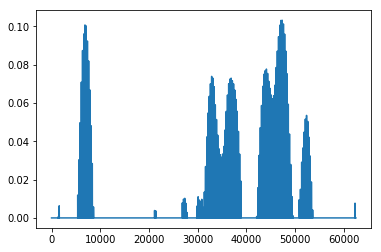

In [20]:
plt.plot(data_plant.reshape(x_del*y_del,))

In [14]:
print(drop_thres)

-0.05359120598153658


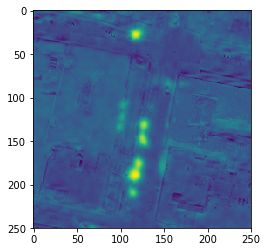

In [193]:
# imgplot = plt.imshow(data_all[:,:,3]-data_ave)
plt.show()
# imgplot = plt.imshow(data_all[:,:,1]-data_ave)
plt.show()
imgplot = plt.imshow((3*data_all[:,:,1] + data_all[:,:,3]) / 4 -data_ave)
plt.show()

In [ ]:
ds.GetMetadata()

In [ ]:
# try and break up tiff
outname = outpath + '/tile_'
ds = gdal.Open(filename)

if not os.path.exists(outpath):
    os.makedirs(outpath)
tile_size_x = ds.RasterXSize//1000
tile_size_y = ds.RasterYSize//1000

band = ds.GetRasterBand(1)
xsize = band.XSize
ysize = band.YSize

for i in range(0, xsize//100, 2*tile_size_x):
# for i in range(0, x, tile_size_x):
    for j in range(0, ysize//100, 2*tile_size_y):
#     for j in range(0, ysize, tile_size_y):
        com_string = ("gdal_translate -of GTIFF -srcwin " + str(i)+ ", " + str(j) + 
                      ", " + str(tile_size_x) + ", " + str(tile_size_y) + " " 
                      + filename + " " + str(outname) 
                      + str(i) + "_" + str(j) + ".tif")
        os.system(com_string)
print('com string example:\n', com_string)

In [ ]:
# Try and open a tif

In [16]:
all_files = glob.glob('./raster_out/*tif')
print('num files:', len(all_files))

('num files:', 36)


In [17]:
print(data.shape)

(10, 10)


In [18]:
data_temp = ds

NameError: name 'ds' is not defined

New image
(4, 43, 43)
0


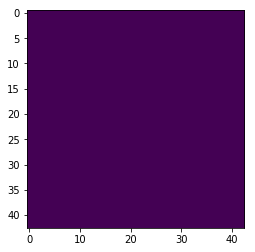

1


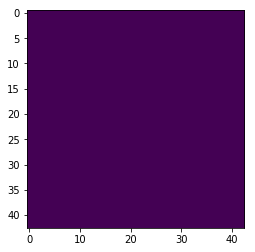

2


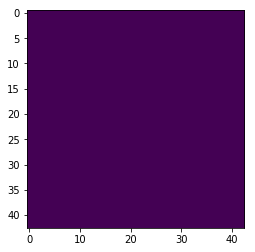

3


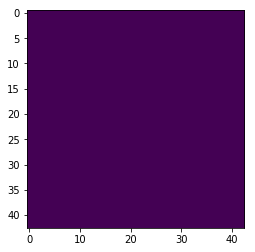

4


IndexError: index 4 is out of bounds for axis 0 with size 4

In [19]:
bands = data.shape[0]

for ii in range(10):
    subsample = all_files[ii]
    ds_sub = gdal.Open(subsample, GA_ReadOnly)
    data = ds_sub.ReadAsArray()
    print('New image')
    print(data.shape)
    for jj in range(bands):
        print(jj)
        imgplot = plt.imshow(data[jj, :, :])
        plt.show()